<a href="https://colab.research.google.com/github/arshmehar/ssh_Indian_Ocean/blob/main/finssh_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import xarray as xr
import numpy as np
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [31]:
# !pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 43.5 MB/s eta 0:00:00


In [3]:
ds = xr.open_dataset("/content/drive/MyDrive/prerna_data/hadgem_aviso.nc", decode_times=False, engine="h5netcdf")
ds = ds.mean(dim="ensemble_member")

X_in = ds.DSL.fillna(0).values
y_in = ds.avisodsl.fillna(0).values


In [4]:
ds

<xarray.Dataset> Size: 365MB
Dimensions:            (TIME: 264, LATITUDE241_480: 240, LONGITUDE841_1200: 360)
Coordinates:
  * TIME               (TIME) float64 2kB 5.15e+04 5.152e+04 ... 5.938e+04
  * LATITUDE241_480    (LATITUDE241_480) float32 960B -29.88 -29.62 ... 29.88
  * LONGITUDE841_1200  (LONGITUDE841_1200) float32 1kB 30.12 30.38 ... 119.9
Data variables:
    DSL                (TIME, LATITUDE241_480, LONGITUDE841_1200) float64 182MB ...
    avisodsl           (TIME, LATITUDE241_480, LONGITUDE841_1200) float64 182MB ...

In [5]:
T, H, W = X_in.shape
print(f"Full cube : T={T}, H={H}, W={W}")#t is time steops, lat, long

Full cube : T=264, H=240, W=360


In [6]:
X_in = X_in.reshape(T, -1)
y_in = y_in.reshape(T, -1)

In [7]:
X_grid = X_in.T     # shape: (H*W, T)
y_grid = y_in.T     # shape: (H*W, T)

In [8]:
n_pixels=X_grid.shape[0]
pix_ids      = np.arange(n_pixels)                 # 0 … 86 399
rng          = np.random.default_rng(42)        # reproducible
rng.shuffle(pix_ids) # permutes the list in‑place; every pixel gets a new random position.

In [9]:
n_train      = int(0.80 * n_pixels)
n_val        = int(0.10 * n_pixels)

train_ids    = pix_ids[:n_train]
val_ids      = pix_ids[n_train:n_train+n_val]
test_ids     = pix_ids[n_train+n_val:]

In [10]:
X_test = X_grid[test_ids]
y_test = y_grid[test_ids]

In [11]:
def make_seq(data_grid, target_grid, steps):
    Xs, ys = [], []
    for gridpoint in range(data_grid.shape[0]):
        for t in range(data_grid.shape[1] - steps):
            Xs.append(data_grid[gridpoint, t:t+steps])
            ys.append(target_grid[gridpoint, t+steps])
    return np.array(Xs)[..., np.newaxis], np.array(ys)



In [12]:
timesteps = 10
X_te, y_te = make_seq(X_test, y_test, timesteps)

In [13]:
model = Sequential([
    LSTM(64, input_shape=(10, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Load weights only
model.load_weights("/content/drive/MyDrive/prerna_data/best_model_epoch0999_val0.003711.h5")

# Then test
loss = model.evaluate(X_te, y_te, batch_size=2048)
print(f"Test Loss: {loss}")

1072/1072 ━━━━━━━━━━━━━━━━━━━━ 54s 50ms/step - loss: 0.0037
Test Loss: 0.0036235731095075607


In [15]:
predictions = model.predict(X_te)
print("Predictions shape:", predictions.shape)  # Expected: (n_samples, 1)


68580/68580 ━━━━━━━━━━━━━━━━━━━━ 158s 2ms/step
Predictions shape: (2194560, 1)


In [33]:
y_te.shape

(2194560,)

In [17]:

from sklearn.metrics import r2_score
# Flatten both arrays to compare all values together
r2 = r2_score(y_te.flatten(), predictions.flatten())
print("R² Score (Overall):", r2)

R² Score (Overall): 0.8194324467643603


In [18]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_te.flatten(), predictions.flatten()))
print("RMSE (Overall):", rmse)


RMSE (Overall): 0.06019611062917556


In [19]:
from scipy.stats import pearsonr

corr, _ = pearsonr(y_te.flatten(), predictions.flatten())
print("Correlation Coefficient (Overall):", corr)


Correlation Coefficient (Overall): 0.9052531683587853


In [20]:
lons = ds.LONGITUDE841_1200.values  # Shape (360,)
lats = ds.LATITUDE241_480.values  # Shape (240,)

In [21]:
##98e 10 s
target_lat, target_lon = -10, 98  # 10°S, 98°E

# Find nearest index
lat_idx = np.argmin(np.abs(lats - target_lat))
lon_idx = np.argmin(np.abs(lons - target_lon))
series = ds.DSL[:, lat_idx, lon_idx]  # Shape: (time,)

# Check if sufficient non-NaNs exist
if np.isnan(series[-timesteps:]).any():
    print("Not enough valid data for prediction at this point.")
else:
    X_point = series[-timesteps:].values.reshape(1, timesteps, 1)  # Convert to NumPy first



In [22]:
prediction = model.predict(X_point)
print("Predicted DSL at 98°E, 10°S:", prediction[0, 0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
Predicted DSL at 98°E, 10°S: -0.027703673


In [23]:
actuals = ds.DSL.values  # or ds['DSL'].values


In [24]:
print(predictions.shape)


(2194560, 1)


In [25]:
series = ds.DSL[:, lat_idx, lon_idx]
target_series = ds.avisodsl[:, lat_idx, lon_idx]


In [26]:
input_series = ds.DSL[:, lat_idx, lon_idx]         # HadGEM (input)
target_series = ds.avisodsl[:, lat_idx, lon_idx]   # AVISO (target)

# Check for valid data in last `timesteps`
if np.isnan(input_series[-timesteps:]).any() or np.isnan(target_series[-1]):
    print("Not enough valid data for prediction at this point.")
else:
    X_point = input_series[-timesteps:].values.reshape(1, timesteps, 1)
    prediction = model.predict(X_point)

    print("Predicted AVISO DSL (next timestep):", prediction[0, 0])
    print("Actual AVISO DSL:", target_series[-1].values)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted AVISO DSL (next timestep): -0.027703673
Actual AVISO DSL: 0.012538470523235645


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


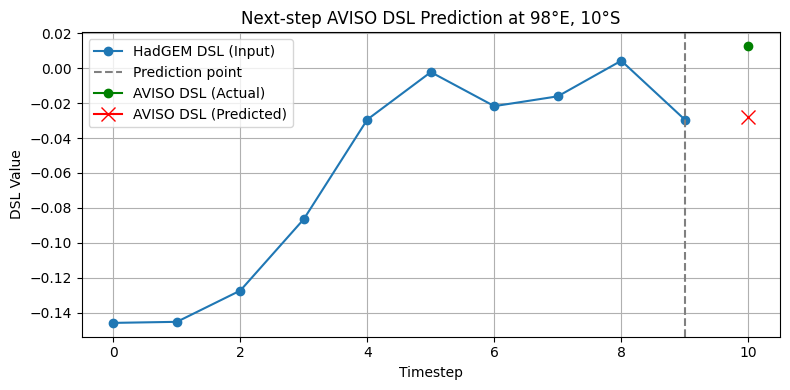

In [27]:
# Make sure last 10 inputs and target are valid
if np.isnan(input_series[-timesteps:]).any() or np.isnan(target_series[-1]):
    print("Not enough valid data for prediction at this point.")
else:
    X_point = input_series[-timesteps:].values.reshape(1, timesteps, 1)
    prediction = model.predict(X_point)

    actual_target = target_series[-1].values

    # Visualization
    past_inputs = input_series[-timesteps:].values.flatten()

    plt.figure(figsize=(8, 4))
    plt.plot(range(timesteps), past_inputs, marker='o', label="HadGEM DSL (Input)")
    plt.axvline(timesteps - 1, color='gray', linestyle='--', label="Prediction point")
    plt.plot(timesteps, actual_target, marker='o', color='green', label="AVISO DSL (Actual)")
    plt.plot(timesteps, prediction[0, 0], marker='x', color='red', markersize=10, label="AVISO DSL (Predicted)")

    plt.title("Next-step AVISO DSL Prediction at 98°E, 10°S")
    plt.xlabel("Timestep")
    plt.ylabel("DSL Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [34]:
##plot on a map

In [35]:
n_timesteps = 10
n_samples_per_pixel = 264 - n_timesteps  # = 254
pixel_index = idx // n_samples_per_pixel
time_offset = idx % n_samples_per_pixel


In [36]:
pixel_id = test_ids[pixel_index]  # gives value from 0 to 86399


In [37]:
lat_idx = pixel_id // 360
lon_idx = pixel_id % 360
lat = lats[lat_idx]   # from ds.LATITUDE241_480.values
lon = lons[lon_idx]   # from ds.LONGITUDE841_1200.values


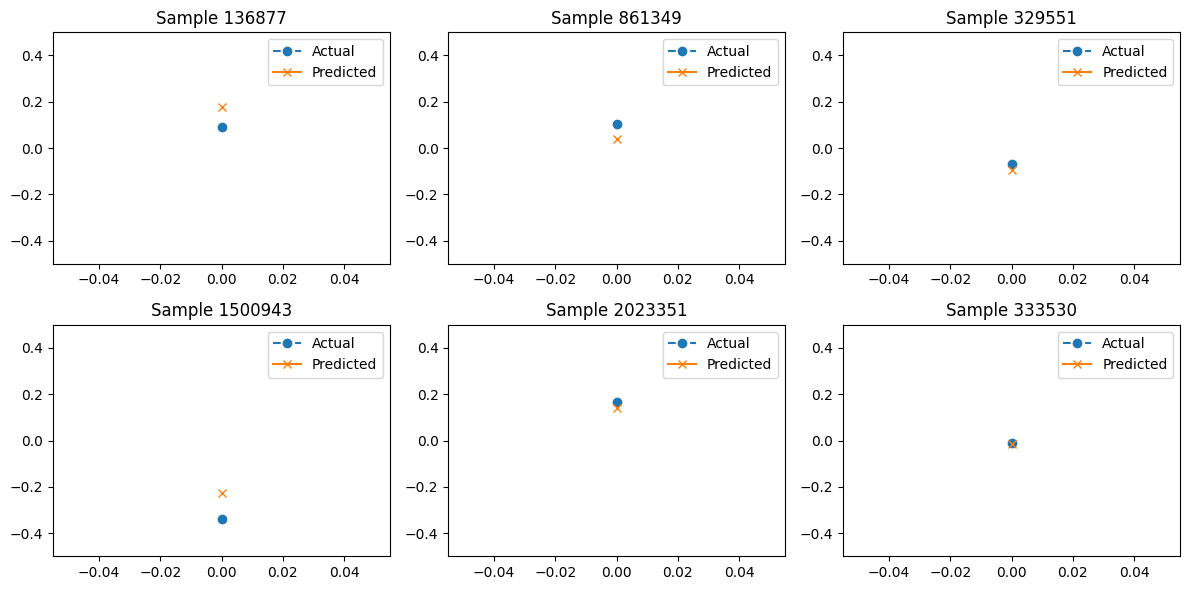

In [45]:
import matplotlib.pyplot as plt
import numpy as np

num_points = 6
random_indices = np.random.choice(len(y_te), num_points, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 3, i + 1)
    plt.plot([0], [y_te[idx]], label="Actual", marker='o', linestyle='dashed')
    plt.plot([0], [predictions[idx][0]], label="Predicted", marker='x')
    plt.title(f"Sample {idx}")
    plt.ylim(-0.5, 0.5)
    plt.legend()

plt.tight_layout()
plt.show()


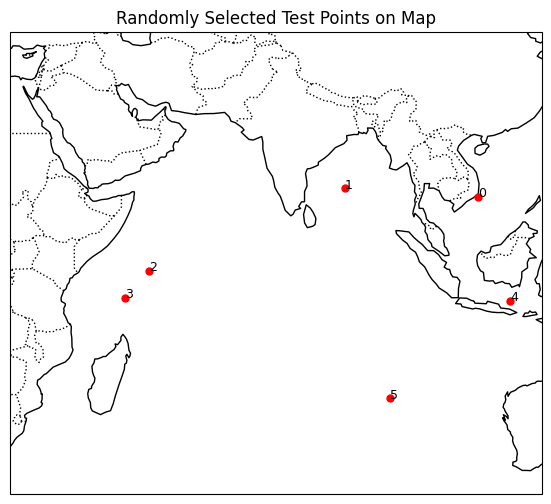

In [46]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

n_timesteps = 10
samples_per_pixel = 264 - n_timesteps  # = 254

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])

for i, idx in enumerate(random_indices):
    pixel_index = idx // samples_per_pixel
    time_offset = idx % samples_per_pixel
    pixel_id = test_ids[pixel_index]
    lat_idx = pixel_id // 360
    lon_idx = pixel_id % 360
    lat = lats[lat_idx]
    lon = lons[lon_idx]

    ax.plot(lon, lat, marker='o', color='red', markersize=5)
    ax.text(lon, lat, f"{i}", fontsize=9)

plt.title("Randomly Selected Test Points on Map")
plt.show()


In [47]:
print(random_indices)

[ 136877  861349  329551 1500943 2023351  333530]
